# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [24]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [25]:
# YOUR CODE HERE
from common_utils import *

def preprocess(df):
    # YOUR CODE HERE
    df.drop(columns=['filename'],inplace=True)
    X_train, y_train, X_test, y_test=split_dataset(df,columns_to_drop=['label'],test_size=0.3,random_state=42)
    #X_train_scaled,X_test_scaled=preprocess_dataset(X_train,X_test)
    return X_train, y_train, X_test, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train, y_train, X_test, y_test = preprocess(df)

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):
    # YOUR CODE HERE
    train_dataloader=DataLoader(CustomDataset(X_train_scaled,y_train),batch_size=batch_size,shuffle=True)
    test_dataloader=DataLoader(CustomDataset(X_test_scaled,y_test),batch_size=batch_size,shuffle=True)
    return train_dataloader, test_dataloader

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [26]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE
    train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

    early_stopper=EarlyStopper()
    n_epochs=100

    train_accuracies=[]
    train_losses=[]
    test_accuracies=[] 
    test_losses=[]
    times=[]
    
    for epoch in range(n_epochs):
        start=time.time()
        overall_train_accuracy=0
        overall_train_loss=0

        model.train()
        for i,(x,y) in enumerate(train_dataloader):
            #forward pass
            pred=model(x)
            loss=loss_fn(pred.squeeze(),y)

            #backward pass and optimise
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            overall_train_loss+=loss.detach()
            overall_train_accuracy+=(pred.round().squeeze()==y).float().mean()

        train_accuracies.append(overall_train_accuracy/len(train_dataloader))
        train_losses.append(overall_train_loss/len(train_dataloader))

        model.eval()
        with torch.no_grad():
            #Test eval
            overall_test_loss=0
            overall_test_accuracy=0
            for x,y in test_dataloader:
                test_pred=model(x)
                overall_test_accuracy+=(test_pred.round().squeeze()==y).float().mean()
                overall_test_loss+=loss_fn(test_pred.squeeze(),y)

        test_accuracies.append(overall_test_accuracy/len(test_dataloader))
        test_losses.append(overall_test_loss/len(test_dataloader))

        if early_stopper.early_stop(overall_test_loss/len(test_dataloader)):
            times.append(time.time()-start)
            break
        if epoch==n_epochs-1:
            times.append(time.time()-start)
    
    torch.save(model.state_dict(),'model.pth')

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [27]:
def find_optimal_hyperparameter(X, y, parameters, mode, batch_size):

    # YOUR CODE HERE
    cross_validation_accuracies={}
    cross_validation_times={}

    for neuron_no in parameters:
        model=MLP(len(df.columns)-1,[neuron_no,128,128],1)
        no_folds=5
        overall_time=0
        val_accuracy=0
        kf=KFold(n_splits=5,shuffle=True,random_state=42)
        for train_index,val_index in kf.split(X):
            X_train=X.iloc[train_index]
            X_val=X.iloc[val_index]
            y_train=y[train_index]
            y_val=y[val_index]

            X_train_scaled,X_val_scaled=preprocess_dataset(X_train,X_val)
            train_accuracies, train_losses, test_accuracies, test_losses, times=train(model, X_train_scaled, y_train, X_val_scaled, y_val, batch_size)
            
            val_accuracy+=test_accuracies[-1]
            overall_time+=times[-1]
            
        cross_validation_accuracies[neuron_no]=val_accuracy/no_folds
        cross_validation_times[neuron_no]=overall_time/no_folds

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, num_neurons, 'num_neurons', 512)

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

Text(0.5, 1.0, 'Cross-Validation accuracy against No of Neurons')

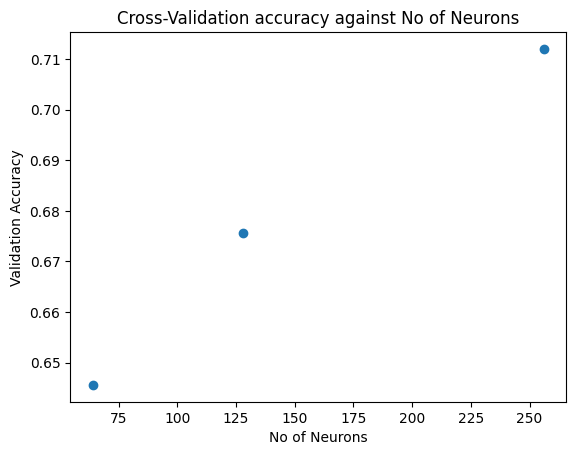

In [28]:
# YOUR CODE HERE
plt.scatter(cross_validation_accuracies.keys(),cross_validation_accuracies.values())
plt.xlabel("No of Neurons")
plt.ylabel("Validation Accuracy")
plt.title("Cross-Validation accuracy against No of Neurons")

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [29]:
optimal_neurons = 256
reason = "It has the highest average validation accuracy for all folds."
# YOUR CODE HERE

X_train_scaled,X_test_scaled=preprocess_dataset(X_train,X_test)
model=MLP(len(df.columns)-1,[optimal_neurons,128,128],1)
batch_size=512
train_accuracies, train_losses, test_accuracies, test_losses, times=train(model, X_train_scaled, y_train, X_test_scaled, y_test, batch_size)

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Text(0.5, 0, 'epoch')

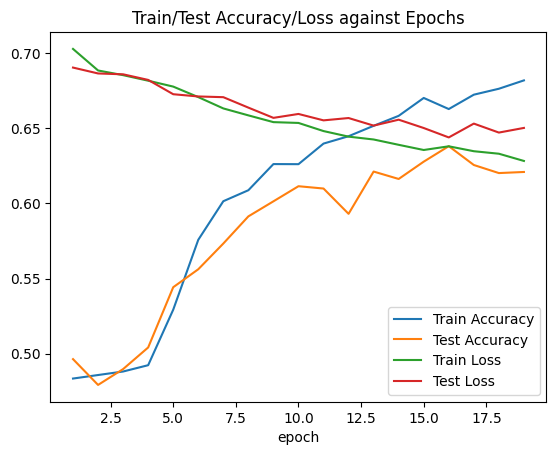

In [30]:
# YOUR CODE HERE
epochs=np.arange(1,len(train_accuracies)+1,1)

plt.figure()
plt.plot(epochs,train_accuracies,label='Train Accuracy')
plt.plot(epochs,test_accuracies,label='Test Accuracy')
plt.plot(epochs,train_losses,label='Train Loss')
plt.plot(epochs,test_losses,label='Test Loss')
plt.title('Train/Test Accuracy/Loss against Epochs')
plt.legend()
plt.xlabel('epoch')